In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
from tqdm import tqdm
import sys
sys.path.append("../src")
from event_selections import *

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
def drop_columns(df):
    #kept_columns=['layer', 'strip', 'pedestal', 'pf_event', 'adc_sum_end0', 'adc_sum_end1', 'end', 'mpv', 'std_dev']
    #df=df[df.columns.intersection(kept_columns)]
    return df

def import_data(calibration_folder, data_folder, run_n):
    pedestals=drop_columns(pd.read_csv(calibration_folder+"/pedestals_MIP.csv", sep=','))
    mips=drop_columns(pd.read_csv(calibration_folder+"/mip.csv", sep=','))
    run=drop_columns(pd.read_csv(data_folder+"/run_"+str(run_n)+"_pulse.csv", sep=','))
    # run=run.astype({"adc_sum_end0":float,"adc_sum_end1":float}) 
    return pedestals,mips,run

In [4]:
def drop_empty(df):
    data=[]

    layers=np.arange(1,20)
    strips=np.arange(0,12)
    
    for layer in layers:
        for strip in strips:
            el=choose_bar(df,layer,strip)
            peds=choose_bar(pedestal_df,layer,strip)
            # for now, we don't deal with conversion to MeV
            #mip=choose_bar(mips, layer, strip)

            if not peds.empty: # need to check whether the strip exists 
                
                # check whetehr signal is large enough
                el=el[el["adc_sum_end0"]>(peds.iloc[0,3]+5*peds.iloc[0,5])] 
                el=el[el["adc_sum_end1"]>(peds.iloc[1,3]+5*peds.iloc[1,5])] 

                # subtract from sum
                el.loc[:,"adc_sum_end0"]-=peds.iloc[0,3]
                el.loc[:,"adc_sum_end1"]-=peds.iloc[1,3]
                
                # subtract from max
                el.loc[:,"adc_max_end0"]-=peds.iloc[0,6]
                el.loc[:,"adc_max_end1"]-=peds.iloc[1,6]

                # subtract from mean
                el.loc[:,"adc_mean_end0"]-=peds.iloc[0,6]
                el.loc[:,"adc_mean_end1"]-=peds.iloc[1,6]
                
                # miniped=peds.iloc[0,-2]/8
                # miniped1=peds.iloc[1,-2]/8

                # subtract from timestamps
                el.loc[:,"adc_0_end0"]-=peds.iloc[0,6]
                el.loc[:,"adc_1_end0"]-=peds.iloc[0,6]
                el.loc[:,"adc_2_end0"]-=peds.iloc[0,6]
                el.loc[:,"adc_3_end0"]-=peds.iloc[0,6]
                el.loc[:,"adc_4_end0"]-=peds.iloc[0,6]
                el.loc[:,"adc_5_end0"]-=peds.iloc[0,6]
                el.loc[:,"adc_6_end0"]-=peds.iloc[0,6]
                el.loc[:,"adc_7_end0"]-=peds.iloc[0,6]

                el.loc[:,"adc_0_end1"]-=peds.iloc[1,6]
                el.loc[:,"adc_1_end1"]-=peds.iloc[1,6]
                el.loc[:,"adc_2_end1"]-=peds.iloc[1,6]
                el.loc[:,"adc_3_end1"]-=peds.iloc[1,6]
                el.loc[:,"adc_4_end1"]-=peds.iloc[1,6]
                el.loc[:,"adc_5_end1"]-=peds.iloc[1,6]
                el.loc[:,"adc_6_end1"]-=peds.iloc[1,6]
                el.loc[:,"adc_7_end1"]-=peds.iloc[1,6]
                
                data.extend(el.values.tolist())
                
    names=list(df.columns)

    df_s=pd.DataFrame(data, columns=names)
    
    return df_s

In [5]:
c_folder="../../data/calibration"
d_folder="../../data/runData"
r_n=300
pulsed=True
p_folder="../../plots/run_"+str(r_n)

In [6]:
pedestal_df, mip_df, run_df=import_data(c_folder, d_folder,r_n)

In [7]:
# first, we drop the TOA columns. TOA has proven to be unreliable in telling whether there is an incoming pulse or not
run_df=run_df.drop(columns=['toa_end0', 'toa_end1'])

In [8]:
# next, we drop every bar that is "empty", meaning that the signal does not go above pedestal + 5 sigma
# we also subtract pedestals in this step
run_df=drop_empty(run_df)

In [114]:
def isolate_pulse_data(row):
    end0 = []
    end1 = []

    for j in range(8):
        adc_end0_col = f'adc_{j}_end0'
        adc_end1_col = f'adc_{j}_end1'
        
        end0_val = row[adc_end0_col]
        end1_val = row[adc_end1_col]
        
        end0.append(end0_val)
        end1.append(end1_val)

    end0 = np.array(end0)
    end1 = np.array(end1)
    return end0,end1

In [149]:
def plot_pulse(end0, end1, layer, bar, event):
    plt.scatter(np.arange(8), end0, label="end0", c="cyan", alpha=0.5)
    plt.scatter(np.arange(8), end1, label="end1", c="magenta", alpha=0.5)
    plt.xlabel("Timestep")
    plt.ylabel("ADC")
    plt.title("Layer: "+str(layer)+" Bar: "+str(bar)+" Event: "+str(event))
    plt.legend()
    plt.show()
    return

In [213]:
def does_pulse_dip(end, p_df, layer, bar, which):
    # get standard deviation of pedestal. I believe this is equivalent to the uncertainty of ani measurement
    # or at least it is a way to approximate that
    
    end_std=p_df[(p_df.layer==layer) & (p_df.strip==bar) & (p_df.end==which)].iloc[0]["pedestal_per_time_sample_std_dev"]

    # I think this doesn't catch dips that have a perfectly flat bottom
    end_diff=np.diff(end)
    end_sign=np.sign(end_diff)
    end_sdiff=np.diff(end_sign)

    dip_loc=np.isin(end_sdiff,2)
    dip_loc=np.append(dip_loc,False)
    dip_value=abs(end_diff[dip_loc])

    if dip_value.size==1 and dip_value>5*end_std:
        return 1
    elif dip_value.size>1 and dip_value.any()>5*end_std:
        print("Something went wrong.")
        return 1
        
    # there could be some failsafe here but I cannot be bothered rn
    return 0
    

In [223]:
def late_filter(end):
    tolerance = 0.2
    if end[-1] >= (end[0] + max(end) * tolerance) or (end[-1] <= end[0] - max(end) * tolerance):

        tolerance = 0.1
        if end[1] <= (end[0] + end[0] * tolerance) and end[1] >= (end[0] - end[0] * tolerance):
            if end[2] <= (end[0] + end[0] * tolerance) and end[2] >= (end[0] - end[0] * tolerance):
                return 1

    return 0

In [246]:
def categorize_pulses(row, p_df):
    out_line=[row.name]
    
    # isolating datapoints from row
    end0, end1=isolate_pulse_data(row)

    # preparing to filter
    layer=row["layer"]    # used as variables to avoid frequent lookup
    bar=row["strip"]
    event=row["pf_event"]

    out_line.append(layer)
    out_line.append(bar)
    out_line.append(event)

    # spike and dip filter
    
    dip_end0=does_pulse_dip(end0, p_df, layer, bar, 0)
    dip_end1=does_pulse_dip(end1, p_df, layer, bar, 1)

    if dip_end0==1 and dip_end1==1:
        #print("Wavy pulse")
        out_line.append(1)
        out_line.append("WAVE")
    elif dip_end0==1 and dip_end1==0:
        #print("Spike in end0")
        out_line.append(1)
        out_line.append("SPIKE_0")
    elif dip_end0==0 and dip_end1==1:
        #print("Spike in end0")
        out_line.append(1)
        out_line.append("SPIKE_1")
    else:
        #print("No dipping")

        late_end0=late_filter(end0)
        late_end1=late_filter(end1)
    
        if late_end0==1 or late_end1==1:
            #print("Late pulse")
            out_line.append(1)
            out_line.append("LATE")
        else:
            #print("Good pulse")
            out_line.append(0)
            out_line.append("NaN")

    
    
    #plot_pulse(end0, end1, layer, bar, event)
    return out_line

In [259]:
tqdm.pandas()
problems=run_df.progress_apply(categorize_pulses, args=(pedestal_df,), axis=1).values.tolist()

100%|████████████████████████████████| 1925514/1925514 [52:45<00:00, 608.23it/s]


In [260]:
pulse_df=pd.DataFrame(problems, columns=["index","layer", "bar", "event", "has_problem", "problem_type"])
pulse_df.set_index("index", inplace=True)

In [261]:
pulse_df.head()

,layer,bar,event,has_problem,problem_type
index,,,,,
0,1.0,0.0,341.0,1,WAVE
1,1.0,0.0,444.0,1,SPIKE_0
2,1.0,0.0,501.0,0,NaN
3,1.0,0.0,878.0,0,NaN
4,1.0,0.0,1024.0,1,WAVE


In [318]:
show_share=pulse_df.drop(["problem_type"], axis=1)

In [362]:
pulse_df[(pulse_df["layer"]==4) & (pulse_df["bar"]==1) & (pulse_df["has_problem"]==1)].groupby("problem_type").count()

,layer,bar,event,has_problem
problem_type,,,,
LATE,2,2,2,2
SPIKE_0,255,255,255,255
SPIKE_1,317,317,317,317
WAVE,1457,1457,1457,1457


In [360]:
pulse_df[(pulse_df["layer"]==7) & (pulse_df["bar"]==1) & (pulse_df["has_problem"]==1)].groupby("problem_type").count()

,layer,bar,event,has_problem
problem_type,,,,
LATE,22,22,22,22
SPIKE_0,304,304,304,304
SPIKE_1,60,60,60,60
WAVE,491,491,491,491


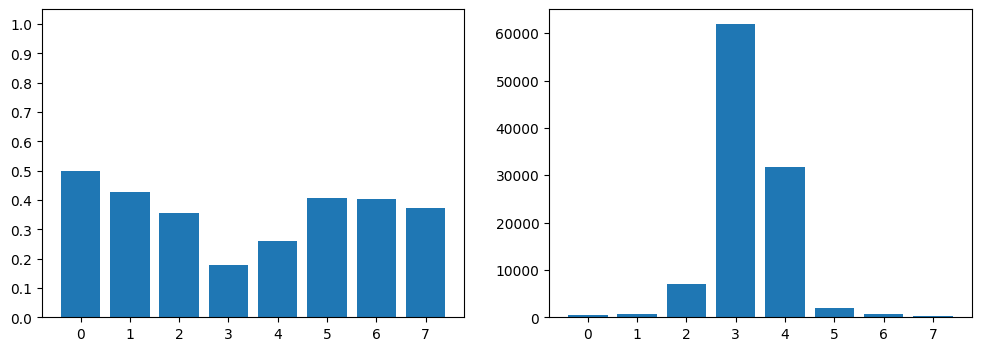

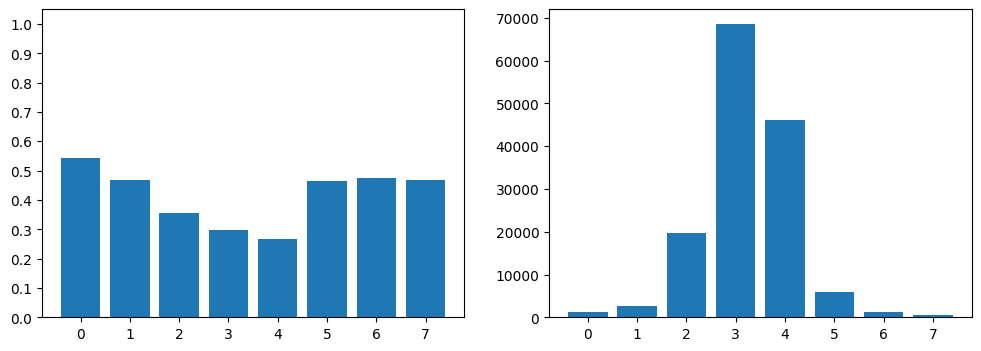

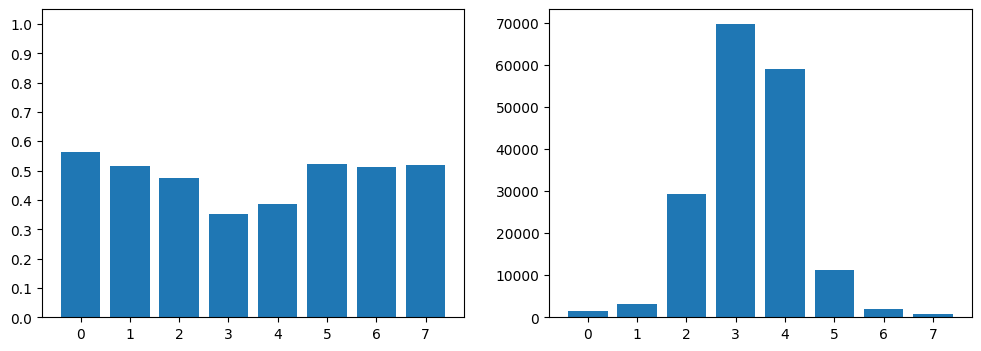

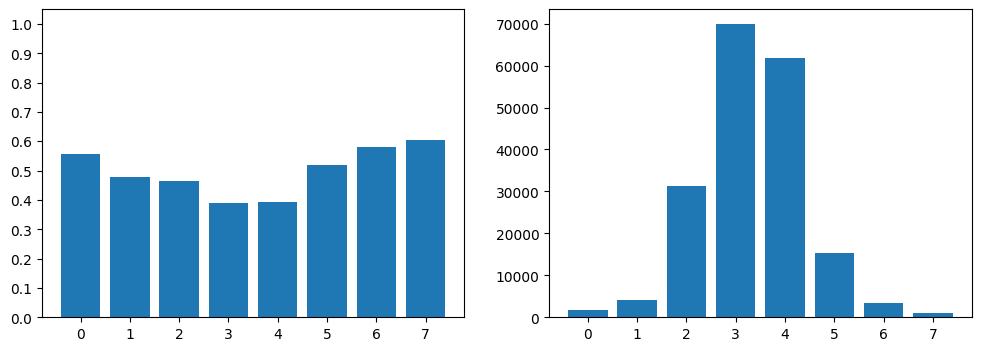

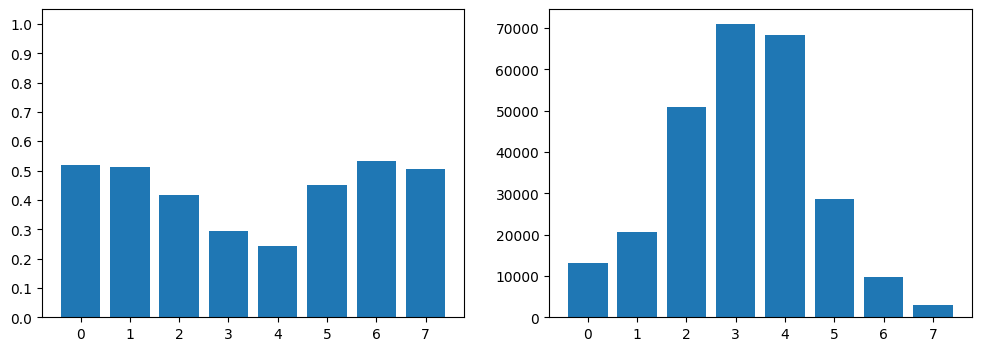

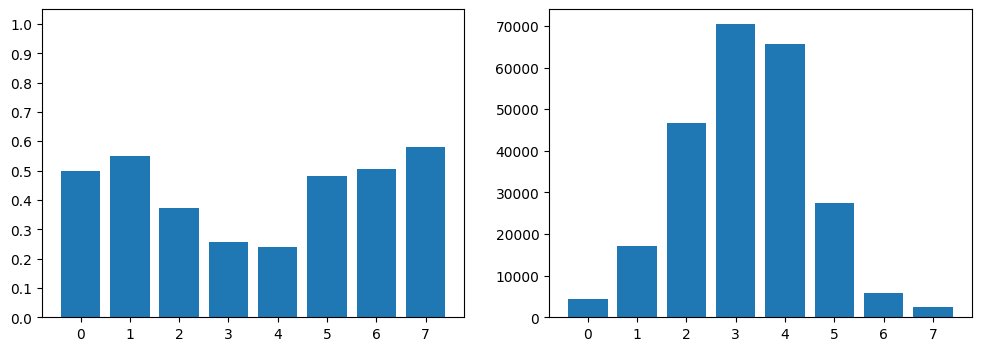

In [351]:
plt.rcParams["figure.figsize"]=(12,4)
for l in range(1,7):
    problem_share=[]
    all_puls_n=[]
    for b in range(0,13):
        n_problem=show_share[(show_share["layer"]==l) & (show_share["bar"]==b) & (show_share["has_problem"]==1)].count()["event"]
        all_pulses=show_share[(show_share["layer"]==l) & (show_share["bar"]==b)].count()["event"]

        if all_pulses!=0:
            problem_share.append(n_problem/all_pulses)
            all_puls_n.append(all_pulses)

    plt.subplot(1,2,1)
    plt.bar(np.arange(len(problem_share)), problem_share)
    plt.ylim(0,1.05)
    plt.yticks(np.arange(0,1.1,0.1))

    plt.subplot(1,2,2)
    plt.bar(np.arange(len(all_puls_n)), all_puls_n)
    
    plt.show()

In [272]:
all_problem=463937
n_pulse=463937+1461577

late=109185
spike=69080+68206
wave=217466

In [275]:
spike/all_problem

0.29591517813841106

In [15]:
def select_faulty_data(data_df, pedestal_df, spike_filter=True, late_trigger_filter=True, dip_filter=True):
    # loop through all events in the dataframe
    print('filtering faulty events...')
    faulty_data_indecies = []
    a=0
    for index, row in tqdm(data_df.iterrows(), total=data_df.shape[0]):
        # extract the pulse shape for the event
        end0 = []
        end1 = []

        for j in range(8):

            adc_end0_col = f'adc_{j}_end0'
            adc_end1_col = f'adc_{j}_end1'

            if adc_end0_col not in row or adc_end1_col not in row:
                print(f"Columns '{adc_end0_col}' or '{adc_end1_col}' do not exist in event {row['pf_event']}, skipping")
                continue

            end0_val = row[adc_end0_col]
            end1_val = row[adc_end1_col]

            if np.isnan(end0_val) or np.isnan(end1_val):
                print(f"NaN value found in '{adc_end0_col}' or '{adc_end1_col}' for event {row['pf_event']}, skipping")
                continue

            end0.append(end0_val)
            end1.append(end1_val)

        end0 = np.array(end0)
        end1 = np.array(end1)
        ends = [end0, end1]

        layer=row["layer"]
        bar=row["strip"]
        for end in ends:
            plt.scatter(np.arange(8), end)
            plt.show()
        """
        # check the pulse shape
        endnum=0
        for end in ends: #always two ends in order of end0, end1
            if spike_filter:
                # Check for spikes in data
                # TODO: change threshold to be dependent on the channel pedestal standard deviation.
                peaks, _ = sig.find_peaks((end * -1 + max(end)), prominence=1.5, threshold=10)
                if len(peaks) >= 1:

                    if index not in faulty_data_indecies:
                        faulty_data_indecies.append(index)
                        #plt.plot(end)
                        #print('peaks: ', peaks)
                        #plt.plot(peaks, np.array(end)[peaks.astype(int)], "x")
                        #plt.show()
                        
            if dip_filter:
                # looks for pulses that are "wavy", for any reason
                d_end=[]
                pedestal_std=pedestal_df[(pedestal_df.layer==layer) & (pedestal_df.strip==bar) & (pedestal_df.end==endnum)].iloc[0]["pedestal_per_time_sample_std_dev"]
                for i in range(1,len(end)):
                    d_end.append(end[i]-end[i-1])
                sign_end=np.sign(d_end)
                for i in range(1,len(sign_end)):
                    dif=sign_end[i]-sign_end[i-1]
                    if dif==2 and abs(d_end[i-1])>5*pedestal_std:
                        if index not in faulty_data_indecies:
                            faulty_data_indecies.append(index)
                

            # check for late triggers in data
            # TODO: this filters away to many good events, make stricter criteria.
            
            if late_trigger_filter:

                tolerance = 0.2
                if end[-1] >= (end[0] + max(end) * tolerance) or (end[-1] <= end[0] - max(end) * tolerance):

                    tolerance = 0.1
                    if end[1] <= (end[0] + end[0] * tolerance) and end[1] >= (end[0] - end[0] * tolerance):
                        if end[2] <= (end[0] + end[0] * tolerance) and end[2] >= (end[0] - end[0] * tolerance):

                            if index not in faulty_data_indecies:
                                faulty_data_indecies.append(index)
            endnum+=1
        """                        
        a+=1
        if a>50:
            break

    print('number of faulty events: ', len(faulty_data_indecies))
    return faulty_data_indecies, len(faulty_data_indecies)

In [124]:
run_df.head()

,pf_event,tot_end0,adc_sum_end0,adc_mean_end0,adc_max_end0,adc_0_end0,adc_1_end0,adc_2_end0,adc_3_end0,adc_4_end0,adc_5_end0,adc_6_end0,adc_7_end0,layer,strip,pf_spill,pf_ticks,tot_end1,adc_sum_end1,adc_mean_end1,adc_max_end1,adc_0_end1,adc_1_end1,adc_2_end1,adc_3_end1,adc_4_end1,adc_5_end1,adc_6_end1,adc_7_end1
0,501.0,0.0,131.0,16.375,45.0,-26.0,-10.0,16.0,27.0,45.0,42.0,21.0,16.0,1.0,0.0,1.0,2363274.0,0.0,126.0,15.750,45.0,-28.0,-7.0,18.0,29.0,45.0,39.0,18.0,12.0
1,878.0,656.0,4166.0,520.750,928.0,2.0,168.0,928.0,928.0,928.0,928.0,160.0,124.0,1.0,0.0,2.0,1553208.0,384.0,2733.0,341.625,918.0,-2.0,94.0,735.0,918.0,515.0,206.0,150.0,117.0
2,1463.0,0.0,600.0,75.000,144.0,-16.0,40.0,92.0,133.0,144.0,103.0,62.0,42.0,1.0,0.0,3.0,1535014.0,0.0,425.0,53.125,105.0,-20.0,22.0,61.0,96.0,105.0,76.0,48.0,37.0
3,1704.0,0.0,193.0,24.125,37.0,6.0,4.0,26.0,32.0,32.0,37.0,34.0,22.0,1.0,0.0,3.0,2393987.0,0.0,152.0,19.000,34.0,-2.0,-6.0,20.0,26.0,28.0,34.0,32.0,20.0
4,1711.0,0.0,57.0,7.125,42.0,-32.0,-20.0,10.0,42.0,26.0,14.0,10.0,7.0,1.0,0.0,3.0,2418493.0,0.0,62.0,7.750,44.0,-32.0,-17.0,13.0,44.0,26.0,12.0,10.0,6.0


In [9]:
pedestal_df.head()

,layer,strip,end,pedestal,mean,std_dev,pedestal_per_time_sample,pedestal_per_time_sample_mean,pedestal_per_time_sample_std_dev
0,1,0,0,760,-1.027374,9.674627,95,94.874186,1.158700
1,1,0,1,840,-7.573053,11.046368,105,104.256295,1.674440
2,1,1,0,760,-2.802681,14.564194,95,94.610470,1.025559
3,1,1,1,760,13.318374,18.856047,95,95.583513,1.358078
4,1,2,0,728,8.016915,10.387670,91,92.069458,1.730582
